In [1]:
import os
import random
import yaml
import torch
import wandb
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torchvision.transforms import ToPILImage, Resize, Compose, Lambda

os.chdir("../")

from module.vae import VariationalAutoEncoder
from module.data import COCOConditionalDataset

### Download Artifact from Wandb

In [ ]:
run = wandb.init()

artifact = run.use_artifact('deepakdhull80/auto-encoder-project/auto-encoder:v45', type='model')
artifact_dir = artifact.download()

### Initialize Model

In [2]:
state_dict = torch.load(f"checkpoints/conditional-variational-autoencoder.pt", map_location="cpu")

In [3]:
cfg = yaml.safe_load(open("config/conditional_vae.yaml", "r"))
cfg['data']['data_prefix_path'] = '/Users/deepakdhull/data/coco/2017'

In [4]:
model = VariationalAutoEncoder(cfg)
model.load_state_dict(state_dict)
model = model.eval()

In [5]:
IMG_SIZE = 64
transform = Compose([Lambda(lambda batch: torch.clamp_(batch * 0.5 + 0.5, min=0, max=1)), Resize((IMG_SIZE, IMG_SIZE), antialias=True), ToPILImage()])

In [6]:
def plot_images(img: list, title: str = "Nothing", figsize=(25,25)):
    print(f"{title} Images")
    _, axs = plt.subplots(1, len(img), figsize=figsize)
    axs = axs.flatten()
    for i, ax in zip(img, axs):
        ax.imshow(i)
        ax.axis('off')
    plt.show()

### Generate Image for random Latent Space

In [7]:
inp = torch.randn(4, 1024)
idx = [0, 1, 0, 1]
conditional = torch.nn.functional.one_hot(torch.tensor(idx), num_classes= cfg['data']['num_classes'])

inp = torch.concat([inp, conditional], dim=1)

with torch.no_grad():
    inp_p = model.decoder(inp)
    print(inp_p.shape)

inp_p = torch.clamp_(inp_p  * 0.5 + 0.5, min=0, max=1)

print(inp_p.min() , inp_p.max())


torch.Size([4, 3, 64, 64])
tensor(0.0005) tensor(0.9663)


In [8]:
imgs = []
for i in range(4):
    imgs.append(np.array(transform(inp_p[i])))

Random Generated Images


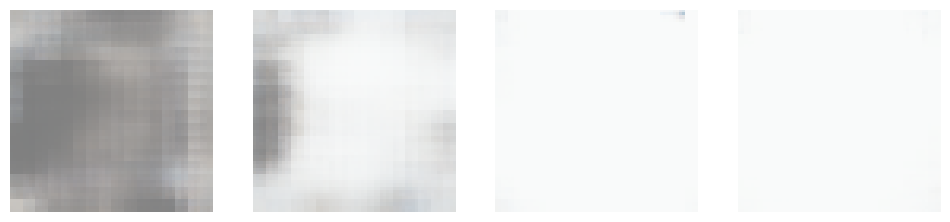

In [9]:
plot_images(imgs, "Random Generated", figsize=(12, 12))

### Generate Back ground images

In [13]:
ds = COCOConditionalDataset(cfg, disable_tansforms=False, train=False)
dl = torch.utils.data.DataLoader(ds, batch_size=8)
batch = next(iter(dl))

In [18]:
img, label = batch

In [19]:
with torch.no_grad():
    out = model(img, label)

In [22]:
output, kl_loss = out

In [26]:
gt_imgs, p_imgs = [], []
for i in range(output.shape[0]):
    gt_imgs.append(np.array(transform(img[i])))
    p_imgs.append(np.array(transform(output[i])))

Ground Truth Images


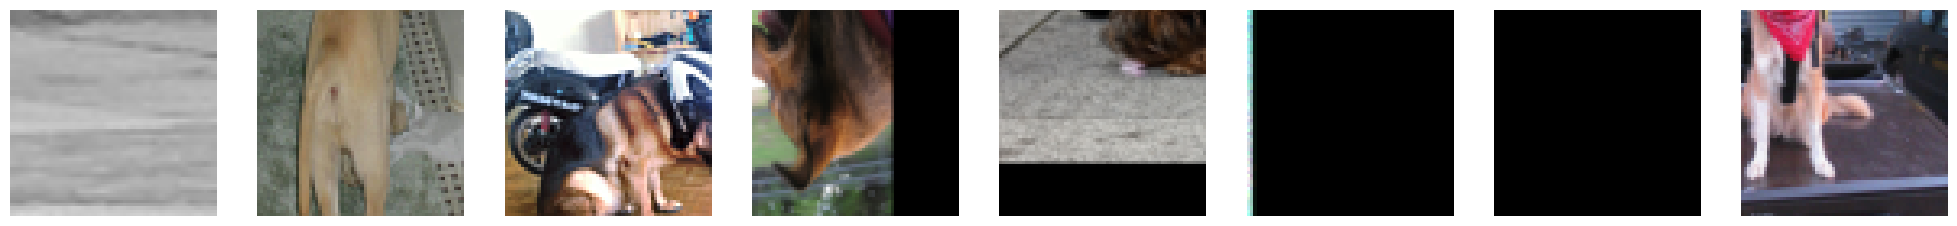

Predicted Images


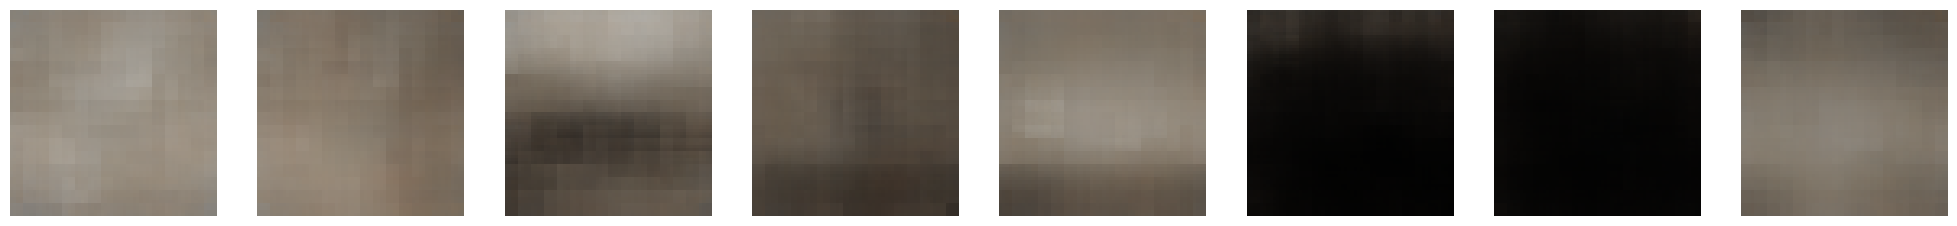

In [27]:
plot_images(gt_imgs, "Ground Truth")
plot_images(p_imgs, "Predicted")